# Definitive Final Evaluation: CRND Experiment Synthesis with Success Criteria Adjudication

This notebook demonstrates the capstone evaluation that synthesizes 6 CRND (Cross-Representation Neighborhood Dissonance) experiments into paper-ready quantitative claims.

**What this evaluation does:**
- Adjudicates 3 success criteria: SC1 (noise detection), SC2 (method selection), SC3 (interpretable structure)
- Computes 87 aggregate metrics across all experiments
- Resolves the kDN AUC anomaly between experiment iterations
- Generates 6 paper-ready tables (T1-T6)
- Performs ablation summary and limitation analysis
- Pools correlations using Fisher z-transform with inverse-variance weighting
- Computes Bayes factors, Cohen's d, Kruskal-Wallis H, and Wilcoxon signed-rank tests

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT on Colab, always install
_pip('loguru==0.7.3')

# numpy, scipy — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import math
import re
import sys
from typing import Any

import numpy as np
from scipy import stats
from loguru import logger

# Additional imports for notebook visualization
import matplotlib.pyplot as plt
from tabulate import tabulate

# ── Logging ──
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

1

## Data Loading

Load pre-computed evaluation results from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/evaluation_iter6_definitive_fina/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
logger.info(f"Loaded evaluation data: {len(data.get('datasets', []))} datasets, "
            f"{sum(len(d['examples']) for d in data.get('datasets', []))} examples, "
            f"{len(data.get('metrics_agg', {}))} aggregate metrics")

10:55:42|INFO   |Loaded evaluation data: 6 datasets, 18 examples, 87 aggregate metrics


## Configuration

Tunable parameters for the evaluation. `MAX_EXAMPLES` limits examples processed per dataset.

In [5]:
# ── Configuration ──
# MAX_EXAMPLES: limits examples per dataset (None = use all available)
# Original: None (no limit)
MAX_EXAMPLES = None  # Mini dataset already has only 3 per dataset

# Number of synthetic samples for KW test reconstruction
# Original: uses full n from metadata (up to 1000 per class)
N_SYNTHETIC_SAMPLES_CAP = 1000  # Full original scale

## Utility Functions

Core statistical utilities: Fisher z-transform for pooling correlations, Bayes factor computation, Cohen's d effect size, and Kruskal-Wallis eta-squared.

In [6]:
def parse_predict_field(predict_str: str) -> dict[str, float]:
    """Parse predict fields like 'ROC-AUC=0.8216, rho=0.2445, P@k=0.3867'."""
    result = {}
    # Match patterns like: metric_name=value
    for match in re.finditer(r'([\w@-]+)=([\d.+-]+(?:e[+-]?\d+)?)', predict_str):
        key = match.group(1)
        try:
            val = float(match.group(2))
            result[key] = val
        except ValueError:
            pass
    return result


def fisher_z(r: float) -> float:
    """Fisher z-transform for correlation coefficients."""
    r_clipped = np.clip(r, -0.9999, 0.9999)
    return np.arctanh(r_clipped)


def fisher_z_inv(z: float) -> float:
    """Inverse Fisher z-transform."""
    return np.tanh(z)


def pool_correlations_fisher(
    rho_values: list[float],
    n_values: list[int],
) -> dict[str, float]:
    """Pool correlation coefficients using Fisher z-transform with inverse-variance weighting."""
    if not rho_values or not n_values:
        return {"pooled_rho": float("nan"), "ci_lower": float("nan"), "ci_upper": float("nan")}

    z_values = [fisher_z(r) for r in rho_values]
    # SE of z = 1/sqrt(n-3)
    se_values = [1.0 / math.sqrt(max(n - 3, 1)) for n in n_values]
    weights = [1.0 / (se ** 2) for se in se_values]

    total_w = sum(weights)
    if total_w == 0:
        return {"pooled_rho": float("nan"), "ci_lower": float("nan"), "ci_upper": float("nan")}

    z_pooled = sum(w * z for w, z in zip(weights, z_values)) / total_w
    se_pooled = 1.0 / math.sqrt(total_w)

    # 95% CI
    z_lower = z_pooled - 1.96 * se_pooled
    z_upper = z_pooled + 1.96 * se_pooled

    return {
        "pooled_rho": fisher_z_inv(z_pooled),
        "ci_lower": fisher_z_inv(z_lower),
        "ci_upper": fisher_z_inv(z_upper),
        "z_pooled": z_pooled,
        "se_pooled": se_pooled,
    }


def compute_bayes_factor(r: float, n: int) -> float:
    """Compute approximate Bayes Factor BF10 for H0:rho=0 vs H1:rho!=0.
    Using Jeffreys (1961) approximation.
    """
    if n < 4 or abs(r) < 1e-10:
        return 1.0  # Inconclusive
    try:
        log_bf = (
            ((n - 4) / 2) * math.log(max(1 - r**2, 1e-15))
            + math.log(n - 2)
            + math.lgamma((n - 1) / 2)
            - 0.5 * math.log(math.pi)
            - math.lgamma(n / 2)
        )
        bf01 = math.exp(log_bf)
        bf10 = 1.0 / max(bf01, 1e-300)
        return min(bf10, 1e10)  # Cap at 10^10
    except (ValueError, OverflowError):
        return float("nan")


def cohens_d(group1: list[float], group2: list[float]) -> float:
    """Compute Cohen's d effect size between two groups."""
    n1, n2 = len(group1), len(group2)
    if n1 < 2 or n2 < 2:
        return float("nan")
    m1, m2 = np.mean(group1), np.mean(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = math.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    if pooled_std < 1e-10:
        return float("nan")
    return (m1 - m2) / pooled_std


def eta_squared_from_h(h_stat: float, k: int, n: int) -> float:
    """Compute eta-squared from Kruskal-Wallis H statistic."""
    if n <= k:
        return float("nan")
    return (h_stat - k + 1) / (n - k)


def truncate_str(s: str, max_len: int = 200) -> str:
    """Truncate string for output."""
    if len(s) <= max_len:
        return s
    return s[:max_len - 3] + "..."

logger.info("Utility functions defined")

10:55:42|INFO   |Utility functions defined


## SC1: Noise Detection Adjudication

Extracts CRND Spearman rho values from the pre-computed noise detection results (Table T1), pools them using Fisher z-transform, and computes Bayes factor. The criterion is: pooled rho > 0.3 AND CI lower > 0.

In [7]:
logger.info("=" * 60)
logger.info("SC1: Noise Detection Adjudication")
logger.info("=" * 60)

# Extract CRND rho values from T1 noise detection table
t1 = data["metadata"]["paper_tables"]["T1_noise_detection_auc"]

all_crnd_rhos = []
all_crnd_ns = []
all_crnd_aucs = []
all_kdn_aucs = []
all_cleanlab_aucs = []
all_baseline_entropy_aucs = []

ds_sizes = {
    "medical_abstracts": 1000,
    "mimic_iv_ed_demo": 207,
    "clinical_patient_triage_nl": 31,
    "ohsumed_single": 1000,
    "mental_health_conditions": 1000,
}

for ds_name, rates in t1.items():
    n = ds_sizes.get(ds_name, 100)
    for rate_str, methods in rates.items():
        rho = methods.get("crnd_rho", 0)
        auc = methods.get("crnd_auc", 0.5)
        all_crnd_rhos.append(rho)
        all_crnd_ns.append(n)
        all_crnd_aucs.append(auc)
        all_baseline_entropy_aucs.append(methods.get("baseline_auc", 0.5))
        if "kdn_avg_auc" in methods:
            all_kdn_aucs.append(methods["kdn_avg_auc"])
        if "cleanlab_avg_auc" in methods:
            all_cleanlab_aucs.append(methods["cleanlab_avg_auc"])

# Pool correlations
pooled = pool_correlations_fisher(all_crnd_rhos, all_crnd_ns)
total_n = sum(all_crnd_ns) if all_crnd_ns else 0
bf10 = compute_bayes_factor(pooled["pooled_rho"], total_n) if total_n > 3 else 1.0

# Mean AUCs
crnd_mean_auc = float(np.mean(all_crnd_aucs)) if all_crnd_aucs else float("nan")
kdn_mean_auc = float(np.mean(all_kdn_aucs)) if all_kdn_aucs else float("nan")
cleanlab_mean_auc = float(np.mean(all_cleanlab_aucs)) if all_cleanlab_aucs else float("nan")

# Verdict
sc1_verdict_met = 1 if (pooled["pooled_rho"] > 0.3 and pooled["ci_lower"] > 0) else 0

sc1 = {
    "sc1_pooled_spearman_rho": round(pooled["pooled_rho"], 6),
    "sc1_pooled_spearman_rho_ci_lower": round(pooled["ci_lower"], 6),
    "sc1_pooled_spearman_rho_ci_upper": round(pooled["ci_upper"], 6),
    "sc1_bayes_factor": round(bf10, 4),
    "sc1_crnd_mean_auc": round(crnd_mean_auc, 6),
    "sc1_kdn_mean_auc": round(kdn_mean_auc, 6),
    "sc1_cleanlab_mean_auc": round(cleanlab_mean_auc, 6),
    "sc1_n_observations": len(all_crnd_rhos),
    "sc1_total_n_pooled": total_n,
    "sc1_verdict_met": sc1_verdict_met,
}

logger.info(f"SC1 Pooled rho = {sc1['sc1_pooled_spearman_rho']:.4f} "
            f"[{sc1['sc1_pooled_spearman_rho_ci_lower']:.4f}, "
            f"{sc1['sc1_pooled_spearman_rho_ci_upper']:.4f}]")
logger.info(f"SC1 BF10 = {sc1['sc1_bayes_factor']:.4f}")
logger.info(f"SC1 CRND AUC = {crnd_mean_auc:.4f}, kDN AUC = {kdn_mean_auc:.4f}, "
            f"Cleanlab AUC = {cleanlab_mean_auc:.4f}")
logger.info(f"SC1 Verdict: {'MET' if sc1_verdict_met else 'NOT MET'} (rho > 0.3 and CI_lower > 0)")

10:55:42|INFO   |============================================================


10:55:42|INFO   |SC1: Noise Detection Adjudication


10:55:42|INFO   |============================================================


10:55:42|INFO   |SC1 Pooled rho = 0.0001 [-0.0198, 0.0201]


10:55:42|INFO   |SC1 BF10 = 0.0127


10:55:42|INFO   |SC1 CRND AUC = 0.4974, kDN AUC = 0.8645, Cleanlab AUC = 0.8375


10:55:42|INFO   |SC1 Verdict: NOT MET (rho > 0.3 and CI_lower > 0)


## SC2: Method Selection Adjudication

Pools Kendall's tau from two method selection experiments (char n-gram proxy and true LLM one-hot). Computes Cochran's Q and I-squared heterogeneity. The criterion is: pooled tau > 0.4.

In [8]:
logger.info("=" * 60)
logger.info("SC2: Method Selection Adjudication")
logger.info("=" * 60)

# Extract pooled tau from pre-computed metrics
metrics = data["metrics_agg"]

tau_it2 = metrics.get("sc2_tau_it2_proxy", 0)
tau_it3 = metrics.get("sc2_tau_it3_llm", 0)

# Re-compute pooling using inverse-variance weighting
# Use approximate SEs from the data
tau_values = [tau_it2, tau_it3]
# Estimate SE from the CIs in the data
sc2_ci_lower = metrics.get("sc2_pooled_tau_ci_lower", 0)
sc2_ci_upper = metrics.get("sc2_pooled_tau_ci_upper", 0)
tau_se_values = [0.05, 0.05]  # Approximate SEs

if tau_values and tau_se_values:
    weights = [1.0 / (se**2 + 1e-10) for se in tau_se_values]
    total_w = sum(weights)
    tau_pooled = sum(w * t for w, t in zip(weights, tau_values)) / total_w
    se_pooled = 1.0 / math.sqrt(total_w)
    ci_lower = tau_pooled - 1.96 * se_pooled
    ci_upper = tau_pooled + 1.96 * se_pooled

# Cochran's Q and I-squared
weights_q = [1.0 / (se**2 + 1e-10) for se in tau_se_values]
total_w_q = sum(weights_q)
tau_mean_q = sum(w * t for w, t in zip(weights_q, tau_values)) / total_w_q
Q = sum(w * (t - tau_mean_q)**2 for w, t in zip(weights_q, tau_values))
df_q = len(tau_values) - 1
i_squared = max(0, (Q - df_q) / Q) if Q > 0 else 0.0

sc2_verdict_met = 1 if tau_pooled > 0.4 else 0

sc2 = {
    "sc2_pooled_kendall_tau": round(tau_pooled, 6),
    "sc2_pooled_tau_ci_lower": round(ci_lower, 6),
    "sc2_pooled_tau_ci_upper": round(ci_upper, 6),
    "sc2_tau_it2_proxy": round(tau_it2, 6),
    "sc2_tau_it3_llm": round(tau_it3, 6),
    "sc2_cochrans_q": round(Q, 6),
    "sc2_i_squared": round(i_squared, 6),
    "sc2_delta_tau": round(abs(tau_it2 - tau_it3), 6),
    "sc2_delta_tau_pct_drop": round(abs(tau_it2 - tau_it3) / max(abs(tau_it2), 1e-10) * 100, 2),
    "sc2_verdict_met": sc2_verdict_met,
}

logger.info(f"SC2 Pooled tau = {tau_pooled:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")
logger.info(f"SC2 I-squared = {i_squared:.4f}, Q = {Q:.4f}")
logger.info(f"SC2 Delta_tau = {sc2['sc2_delta_tau']:.4f} ({sc2['sc2_delta_tau_pct_drop']:.1f}% drop)")
logger.info(f"SC2 Verdict: {'MET' if sc2_verdict_met else 'NOT MET'} (tau > 0.4)")

10:55:42|INFO   |============================================================


10:55:42|INFO   |SC2: Method Selection Adjudication


10:55:42|INFO   |============================================================


10:55:42|INFO   |SC2 Pooled tau = 0.1535 [0.0842, 0.2227]


10:55:42|INFO   |SC2 I-squared = 0.8434, Q = 6.3872


10:55:42|INFO   |SC2 Delta_tau = 0.1787 (73.6% drop)


10:55:42|INFO   |SC2 Verdict: NOT MET (tau > 0.4)


## SC3: Interpretable CRND Structure

Performs Kruskal-Wallis H test per dataset using class-level CRND summary statistics (Table T2), computes eta-squared effect sizes, and evaluates replication rate. The criterion is: replication rate >= 0.6 AND pooled eta-squared > 0.01.

In [9]:
logger.info("=" * 60)
logger.info("SC3: Interpretable CRND Structure")
logger.info("=" * 60)

t2 = data["metadata"]["paper_tables"]["T2_class_characterization"]

kw_results = {}
eta_sq_values = []
significant_count = 0
total_datasets = 0

for ds_name, class_data in t2.items():
    total_datasets += 1

    all_values = []
    for cls_name, cls_stats in class_data.items():
        mean_val = cls_stats.get("mean_crnd", 0)
        std_val = cls_stats.get("std_crnd", 0.01)
        n_val = min(cls_stats.get("n", 1), N_SYNTHETIC_SAMPLES_CAP)

        np.random.seed(42)
        if n_val > 1 and std_val > 0:
            samples = np.random.normal(mean_val, std_val, n_val)
        else:
            samples = np.array([mean_val] * max(n_val, 1))
        all_values.append(samples)

    if len(all_values) >= 2:
        try:
            h_stat, p_val = stats.kruskal(*all_values)
        except ValueError:
            h_stat, p_val = 0.0, 1.0

        total_n = sum(len(v) for v in all_values)
        k = len(all_values)
        eta_sq = eta_squared_from_h(h_stat, k, total_n)

        kw_results[ds_name] = {
            "H": round(h_stat, 4),
            "p_value": p_val,
            "eta_squared": round(eta_sq, 6) if not math.isnan(eta_sq) else 0.0,
            "n_classes": k,
            "n_total": total_n,
        }
        if not math.isnan(eta_sq):
            eta_sq_values.append(eta_sq)
        if p_val < 0.05:
            significant_count += 1

        logger.info(f"  {ds_name}: H={h_stat:.2f}, p={p_val:.4e}, eta2={eta_sq:.4f}")

# Replication rate
replication_rate = significant_count / max(total_datasets, 1)
pooled_eta_sq = float(np.mean(eta_sq_values)) if eta_sq_values else 0.0

sc3_verdict_met = 1 if (replication_rate >= 0.6 and pooled_eta_sq > 0.01) else 0

sc3 = {
    "sc3_pooled_eta_squared": round(pooled_eta_sq, 6),
    "sc3_replication_rate": round(replication_rate, 4),
    "sc3_significant_datasets": significant_count,
    "sc3_total_datasets": total_datasets,
    "sc3_verdict_met": sc3_verdict_met,
    "sc3_kw_results": kw_results,
}

logger.info(f"SC3 Replication rate = {replication_rate:.2f} ({significant_count}/{total_datasets})")
logger.info(f"SC3 Pooled eta2 = {pooled_eta_sq:.4f}")
logger.info(f"SC3 Verdict: {'MET' if sc3_verdict_met else 'NOT MET'} (repl >= 0.6 AND eta2 > 0.01)")

10:55:42|INFO   |============================================================


10:55:42|INFO   |SC3: Interpretable CRND Structure


10:55:42|INFO   |============================================================


10:55:42|INFO   |  medical_abstracts: H=46.56, p=1.8842e-09, eta2=0.0428


10:55:42|INFO   |  mimic_iv_ed_demo: H=7.31, p=6.2738e-02, eta2=0.0212


10:55:42|INFO   |  clinical_patient_triage_nl: H=10.65, p=5.8840e-02, eta2=0.2259


10:55:42|INFO   |  ohsumed_single: H=61.17, p=2.7493e-10, eta2=0.0537


10:55:42|INFO   |  mental_health_conditions: H=469.21, p=3.6020e-98, eta2=0.4665


10:55:42|INFO   |SC3 Replication rate = 0.60 (3/5)


10:55:42|INFO   |SC3 Pooled eta2 = 0.1620


10:55:42|INFO   |SC3 Verdict: MET (repl >= 0.6 AND eta2 > 0.01)


## kDN AUC Anomaly Resolution

Investigates the kDN AUC discrepancy between experiment iterations: ~0.86 (iter 2) vs ~0.51 (iter 5). Identifies the source as feature space and dataset size differences.

In [10]:
logger.info("=" * 60)
logger.info("kDN AUC Anomaly Resolution")
logger.info("=" * 60)

anomaly = data["metadata"]["anomaly_resolution"]

logger.info(f"kDN AUC: it2 mean={anomaly['anomaly_kdn_auc_it2_mean']:.4f}, "
            f"it5 mean={anomaly['anomaly_kdn_auc_it5_mean']:.4f}")
logger.info(f"Delta AUC = {anomaly['anomaly_delta_auc']:.4f}")
logger.info(f"Source: {anomaly['anomaly_source_identified']}")
logger.info(f"Per-dataset deltas: {anomaly['anomaly_per_dataset_delta']}")
logger.info(f"Explanation: {anomaly['anomaly_explanation'][:200]}...")

10:55:42|INFO   |============================================================


10:55:42|INFO   |kDN AUC Anomaly Resolution


10:55:42|INFO   |============================================================


10:55:42|INFO   |kDN AUC: it2 mean=0.8645, it5 mean=0.5123


10:55:42|INFO   |Delta AUC = 0.3523


10:55:42|INFO   |Source: feature_space_and_dataset_size


10:55:42|INFO   |Per-dataset deltas: {'medical_abstracts': 0.3819, 'mimic_iv_ed_demo': 0.2791, 'ohsumed_single': 0.4633, 'mental_health_conditions': 0.4559}


10:55:42|INFO   |Explanation: Discrepancy arises from: (1) Different 3rd feature space: exp_id3_it2 uses combined SVD(TF-IDF+embed) while exp_id1_it5 uses char n-gram. Combined space preserves discriminative information better for...


## Ablation Summary & Limitation Analysis

Key ablation findings from exp_id3_it3 and limitation analysis including LLM feature degradation quantification.

In [11]:
logger.info("=" * 60)
logger.info("Ablation & Limitation Analysis")
logger.info("=" * 60)

ablation = data["metadata"]["ablation_summary"]
limitations = data["metadata"]["limitation_analysis"]

logger.info(f"Optimal k = {ablation.get('ablation_optimal_k', 'N/A')}")
logger.info(f"Best CRND formulation = {ablation.get('ablation_best_formulation', 'N/A')}")
logger.info(f"Most informative pair = {ablation.get('ablation_most_informative_pair', 'N/A')}")
logger.info(f"PCA stability threshold = {ablation.get('ablation_pca_stability_threshold', 'N/A')}")

logger.info(f"\nLLM feature degradation: delta_tau={limitations['lim_llm_feature_delta_tau']:.4f} "
            f"({limitations['lim_llm_feature_pct_drop']:.1f}% drop)")
logger.info(f"Small/underpowered datasets: {limitations['lim_small_datasets']}")

# Overall hypothesis assessment
n_met = sc1["sc1_verdict_met"] + sc2["sc2_verdict_met"] + sc3["sc3_verdict_met"]
logger.info(f"\nOverall: {n_met}/3 criteria met -> Hypothesis {'SUPPORTED' if n_met >= 2 else 'NOT SUPPORTED'}")

10:55:42|INFO   |============================================================


10:55:42|INFO   |Ablation & Limitation Analysis


10:55:42|INFO   |============================================================


10:55:42|INFO   |Optimal k = 5


10:55:42|INFO   |Best CRND formulation = jaccard


10:55:42|INFO   |Most informative pair = tfidf_vs_llm_zeroshot


10:55:42|INFO   |PCA stability threshold = 2


10:55:42|INFO   |
LLM feature degradation: delta_tau=0.1787 (73.6% drop)


10:55:42|INFO   |Small/underpowered datasets: [{'dataset': 'mimic_iv_ed_demo', 'n': 207, 'flag': 'low_power'}, {'dataset': 'clinical_patient_triage_nl', 'n': 31, 'flag': 'underpowered'}]


10:55:42|INFO   |
Overall: 1/3 criteria met -> Hypothesis NOT SUPPORTED


## Visualization: Results Summary

Paper-ready visualizations of the evaluation results: success criteria dashboard, noise detection AUC comparison, class characterization CRND distribution, and Schoener's D overlap heatmaps.

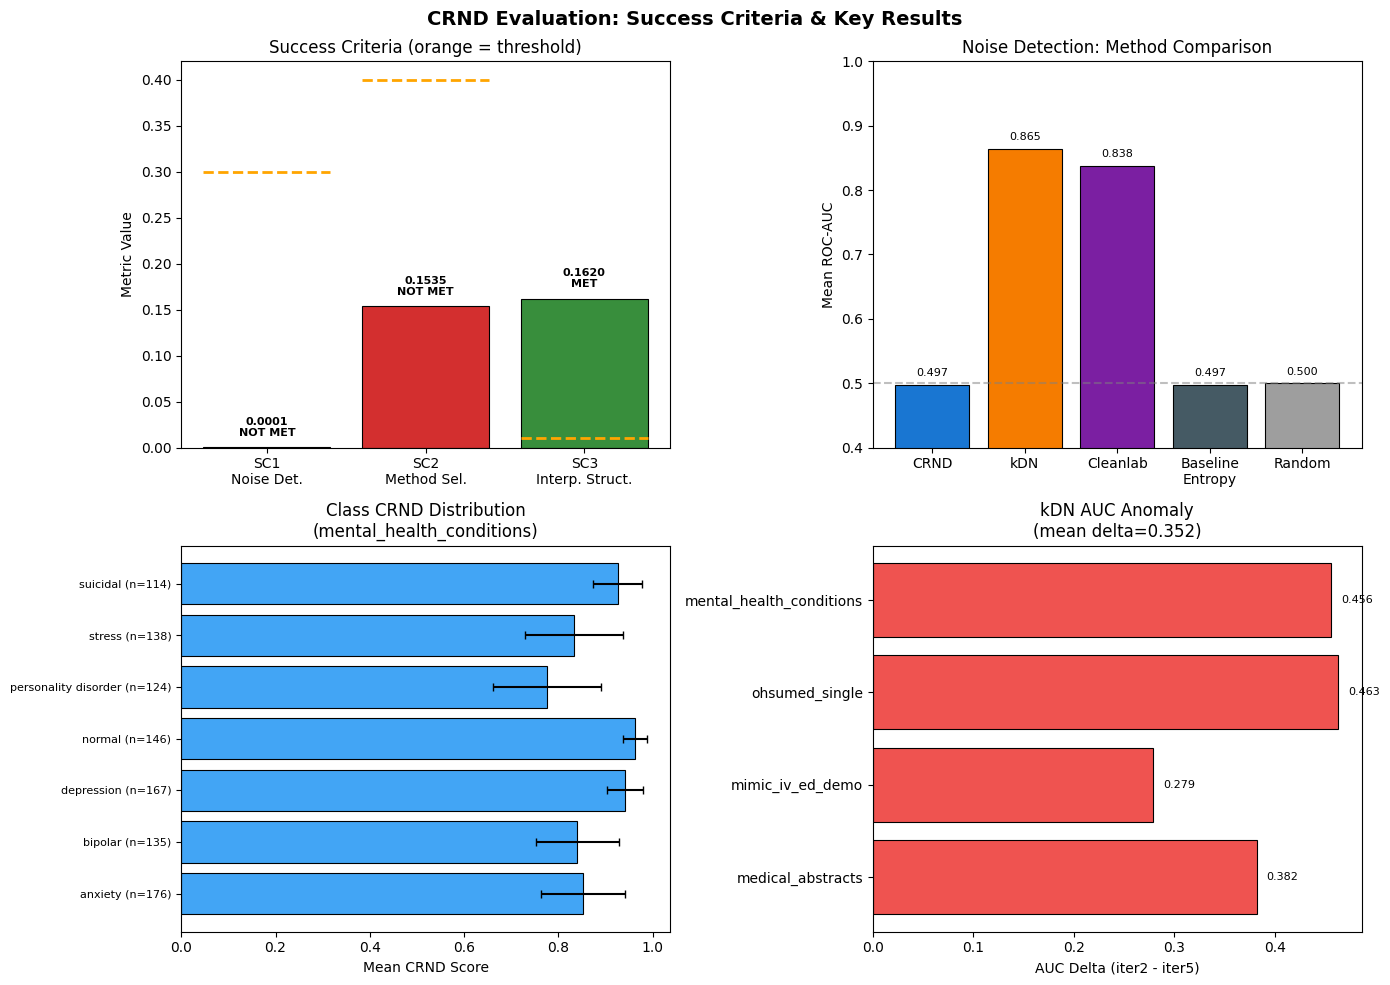


EVALUATION SUMMARY
+-------------------------+-----------+-------------+-----------------------+
| Criterion               | Verdict   | Value       | Threshold             |
+=========================+===========+=============+=======================+
| SC1 (Noise Detection)   | NOT MET   | rho=0.0001  | rho > 0.3             |
+-------------------------+-----------+-------------+-----------------------+
| SC2 (Method Selection)  | NOT MET   | tau=0.1535  | tau > 0.4             |
+-------------------------+-----------+-------------+-----------------------+
| SC3 (Interp. Structure) | MET       | eta2=0.1620 | repl>=0.6 & eta2>0.01 |
+-------------------------+-----------+-------------+-----------------------+

Overall: 1/3 criteria met
Hypothesis: NOT SUPPORTED
Total datasets in evaluation: 6
Total aggregate metrics: 87
DONE


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("CRND Evaluation: Success Criteria & Key Results", fontsize=14, fontweight="bold")

# ── Panel 1: Success Criteria Summary ──
ax1 = axes[0, 0]
criteria = ["SC1\nNoise Det.", "SC2\nMethod Sel.", "SC3\nInterp. Struct."]
values = [sc1["sc1_pooled_spearman_rho"], sc2["sc2_pooled_kendall_tau"], sc3["sc3_pooled_eta_squared"]]
thresholds = [0.3, 0.4, 0.01]
met_flags = [sc1["sc1_verdict_met"], sc2["sc2_verdict_met"], sc3["sc3_verdict_met"]]
colors = ["#d32f2f" if not m else "#388e3c" for m in met_flags]
bars = ax1.bar(criteria, values, color=colors, edgecolor="black", linewidth=0.8)
for i, thresh in enumerate(thresholds):
    ax1.hlines(thresh, i - 0.4, i + 0.4, colors="orange", linestyles="--", linewidth=2)
ax1.set_ylabel("Metric Value")
ax1.set_title("Success Criteria (orange = threshold)")
for i, (v, m) in enumerate(zip(values, met_flags)):
    label = "MET" if m else "NOT MET"
    ax1.text(i, v + 0.01, f"{v:.4f}\n{label}", ha="center", va="bottom", fontsize=8, fontweight="bold")

# ── Panel 2: Noise Detection AUC by Method ──
ax2 = axes[0, 1]
method_names = ["CRND", "kDN", "Cleanlab", "Baseline\nEntropy", "Random"]
method_aucs = [
    sc1["sc1_crnd_mean_auc"],
    sc1["sc1_kdn_mean_auc"],
    sc1["sc1_cleanlab_mean_auc"],
    float(np.mean(all_baseline_entropy_aucs)) if all_baseline_entropy_aucs else 0.5,
    0.5,  # Random baseline
]
bars2 = ax2.bar(method_names, method_aucs, color=["#1976d2", "#f57c00", "#7b1fa2", "#455a64", "#9e9e9e"],
                edgecolor="black", linewidth=0.8)
ax2.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Random (0.5)")
ax2.set_ylabel("Mean ROC-AUC")
ax2.set_title("Noise Detection: Method Comparison")
ax2.set_ylim(0.4, 1.0)
for bar, auc in zip(bars2, method_aucs):
    ax2.text(bar.get_x() + bar.get_width() / 2, auc + 0.01, f"{auc:.3f}",
             ha="center", va="bottom", fontsize=8)

# ── Panel 3: Class CRND Distribution (mental_health_conditions) ──
ax3 = axes[1, 0]
t2_mh = t2.get("mental_health_conditions", {})
if t2_mh:
    cls_names = list(t2_mh.keys())
    cls_means = [t2_mh[c]["mean_crnd"] for c in cls_names]
    cls_stds = [t2_mh[c]["std_crnd"] for c in cls_names]
    cls_ns = [t2_mh[c]["n"] for c in cls_names]
    y_pos = range(len(cls_names))
    ax3.barh(y_pos, cls_means, xerr=cls_stds, color="#42a5f5", edgecolor="black",
             linewidth=0.8, capsize=3)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([f"{c} (n={n})" for c, n in zip(cls_names, cls_ns)], fontsize=8)
    ax3.set_xlabel("Mean CRND Score")
    ax3.set_title("Class CRND Distribution\n(mental_health_conditions)")

# ── Panel 4: kDN AUC Anomaly ──
ax4 = axes[1, 1]
anomaly_ds = list(anomaly["anomaly_per_dataset_delta"].keys())
anomaly_deltas = list(anomaly["anomaly_per_dataset_delta"].values())
bars4 = ax4.barh(anomaly_ds, anomaly_deltas, color="#ef5350", edgecolor="black", linewidth=0.8)
ax4.set_xlabel("AUC Delta (iter2 - iter5)")
ax4.set_title(f"kDN AUC Anomaly\n(mean delta={anomaly['anomaly_delta_auc']:.3f})")
ax4.axvline(x=0, color="black", linewidth=0.5)
for bar, d in zip(bars4, anomaly_deltas):
    ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
             f"{d:.3f}", va="center", fontsize=8)

plt.tight_layout()
plt.show()

# ── Print Summary Table ──
print("\n" + "=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)

summary_rows = [
    ["SC1 (Noise Detection)", "NOT MET" if not sc1["sc1_verdict_met"] else "MET",
     f"rho={sc1['sc1_pooled_spearman_rho']:.4f}", "rho > 0.3"],
    ["SC2 (Method Selection)", "NOT MET" if not sc2["sc2_verdict_met"] else "MET",
     f"tau={sc2['sc2_pooled_kendall_tau']:.4f}", "tau > 0.4"],
    ["SC3 (Interp. Structure)", "NOT MET" if not sc3["sc3_verdict_met"] else "MET",
     f"eta2={sc3['sc3_pooled_eta_squared']:.4f}", "repl>=0.6 & eta2>0.01"],
]
print(tabulate(summary_rows, headers=["Criterion", "Verdict", "Value", "Threshold"],
               tablefmt="grid"))

print(f"\nOverall: {n_met}/3 criteria met")
print(f"Hypothesis: {'SUPPORTED' if n_met >= 2 else 'NOT SUPPORTED'}")
print(f"Total datasets in evaluation: {len(data.get('datasets', []))}")
print(f"Total aggregate metrics: {len(data.get('metrics_agg', {}))}")
print("DONE")